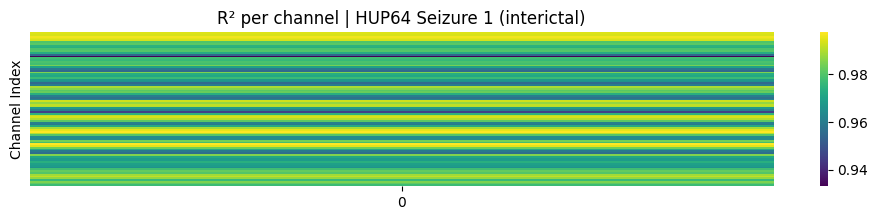

TypeError: Cannot interpret '98' as a data type

In [ ]:
import numpy as np 
import os 
import scipy.io
from sklearn.metrics import r2_score 
import matplotlib.pyplot as plt
import seaborn as sns
main_pathname = 'c:/Users/yaoyu/Documents/Epilepsy_research/'
window_length = 3
stride = 1
# Checking abnormal patients, making sure FOS fits corrects 

patients = ['HUP64', 'HUP68','HUP72','HUP78','HUP86','MAYO010','MAYO011','MAYO016','MAYO020']
patients = ['HUP64']
for patient in patients: 
    for seizure in range(1, 9):
        for phase in ['interictal', 'ictal']:
            path = os.path.join(main_pathname, 'data_v2', patient, f'{phase}-block-{seizure}_parameters_3sec_1iter.mat')
            if(os.path.exists(path)):
                parameters = scipy.io.loadmat(path)
                raw_signal = scipy.io.loadmat(os.path.join(main_pathname, 'data', patient, f'{patient}-{phase}-block-{seizure}.mat'))

                alpha = parameters['alpha']
                A_matrix = parameters['A']
                xPred = parameters['xPred']
                evData = raw_signal['evData']
                sampling_rate = int(np.ceil(raw_signal['Fs'][0][0]))
                window_samples = sampling_rate*window_length
                stride_samples = sampling_rate*stride
                num_chns, data_points = evData.shape
                windows = alpha.shape[1]

                counts = np.zeros(data_points)
                evData_centered = np.zeros_like(evData)
                # need to locally center windowed raw data for r squared
                for window, start_idx in enumerate(range(0, data_points - window_samples + 1, stride_samples)):
                    X = evData[:, start_idx:start_idx + window_samples]
                    X = X - np.mean(X, axis = 1, keepdims=True)
                    evData_centered[:, start_idx:start_idx + window_samples] += X
                    counts[start_idx:start_idx + window_samples] += 1

                counts[counts == 0] = 1
                evData_centered /= counts[np.newaxis, :]

                # 1xchannel heatmap 

                r2_scores = [r2_score(evData_centered[ch], xPred[ch]) for ch in range(num_chns)]

                plt.figure(figsize=(12, 2))
                sns.heatmap(np.array(r2_scores).reshape(-1, 1), cmap='viridis', cbar=True, yticklabels=True)
                plt.title(f'R² per channel | {patient} Seizure {seizure} ({phase})')
                plt.ylabel('Channel Index')
                plt.xlabel('')
                plt.yticks([])
                plt.show()

                # temporal heatmap 
                # 1 second chunks for r2
                r2_temporal = np.zeros_like((num_chns, windows))
                for i in range(windows):
                    window_slice = slice(i*sampling_rate, (i+1)*sampling_rate)
                    for ch in range(num_chns):
                        try:
                            r2_temporal[ch, i] = r2_score(evData_centered[ch, window_slice], xPred[ch, window_slice])
                        except: 
                            r2_temporal[ch, i] = np.nan 
                
                plt.figure(figsize=(12, 8))
                sns.heatmap(r2_temporal, cmap='viridis', vmin=0, vmax=1, cbar=True)

                # Label axes
                plt.title(f'Temporal R² | {patient} Seizure {seizure} ({phase})')
                plt.xlabel('Time (s)')
                plt.ylabel('Channel Index')

                # Time ticks in seconds
                xtick_locs = np.linspace(0, windows - 1, 6, dtype=int)
                xtick_labels = [str(i) for i in xtick_locs]
                plt.xticks(xtick_locs, xtick_labels)

                plt.tight_layout()
                plt.show()

